# Generate Bounding Boxes

In [1]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, convert_map_to_road_map

from bb_helper import coordinates_to_binary_tensor, batch_coordinates_to_binary_tensor

from PIL import Image
import cv2

import time

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

In [3]:
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '..\\..\\data'
annotation_csv = '../../data/annotation.csv'

In [4]:
transform = torchvision.transforms.ToTensor()

In [5]:
# unlabeled_scene_index = np.arange(106)
labeled_scene_index = np.arange(125, 134) # default (106, 134)

In [6]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=False # Can change to true and get extra info
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn)

In [7]:
sample, target, road_image, boxes = iter(trainloader).next()
print(torch.stack(sample).shape)

torch.Size([2, 6, 3, 256, 306])


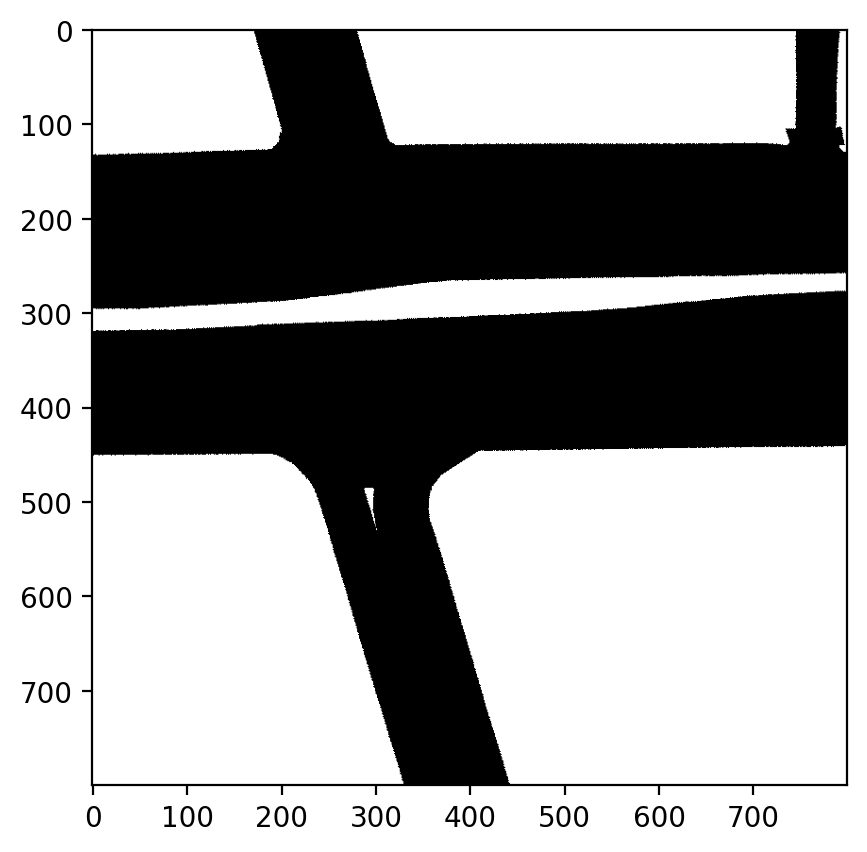

In [8]:
# The road map layout is encoded into a binary array of size [800, 800] per sample 
# Each pixel is 0.1 meter in physiscal space, so 800 * 800 is 80m * 80m centered at the ego car
# The ego car is located in the center of the map (400, 400) and it is always facing the left

fig, ax = plt.subplots()

ax.imshow(road_image[0], cmap='binary');

# Convert bounding box coordinates to binary map

In [9]:
def draw_black_box(ax, corners):
    point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2], corners[:, 0]])
    ax.plot(point_squence.T[0] * 10 + 400, -point_squence.T[1] * 10 + 400, color='black', linewidth=0.5)

In [10]:
### Plot empty background (or negative roadmap) ###
fig, ax = plt.subplots()
plt.axis('off')
background = torch.zeros((800,800)) > 0
# background = road_image[0] != True
ax.imshow(background, cmap='binary');

### Draw Boxes ###
for i, bb in enumerate(boxes[0]):
    draw_black_box(ax, bb)

### Ensure DPI is Correct and Save Image ###
DPI = 200
matplotlib.rcParams['figure.dpi'] = DPI
fig.set_size_inches(800.0/float(DPI),800.0/float(DPI))
fig.canvas.draw()
plt.close(fig)


In [11]:
# Now we can save it to a numpy array.
bb_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
bb_image = bb_image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
bb_image_gray = cv2.cvtColor(bb_image,cv2.COLOR_BGR2GRAY)
bb_image_binary = torch.tensor(bb_image_gray) < 255

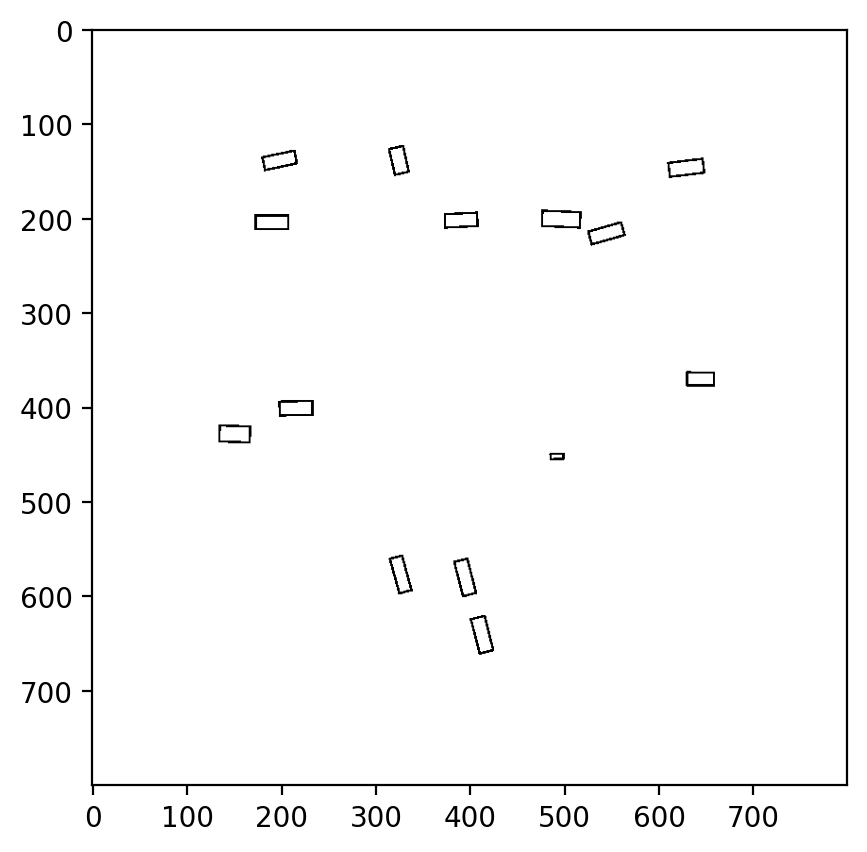

In [12]:
bb_image_binary.shape
fig, ax = plt.subplots()
ax.imshow(bb_image_binary, cmap='binary');

In [13]:
output_tensors = []
for box_element in boxes:
    bb_image_binary = coordinates_to_binary_tensor(box_element)
    output_tensors.append(bb_image_binary)
output_tensors_stacked = torch.stack(output_tensors)
output_tensors_stacked.shape

torch.Size([2, 800, 800])

In [14]:
output_tensors_stacked = batch_coordinates_to_binary_tensor(boxes)
output_tensors_stacked.shape

torch.Size([2, 800, 800])

# Convert binary map to bounding box coordinates

In [ ]:
bb_image_gray.shape

In [ ]:
# Find Canny edges 
edged = cv2.Canny(bb_image_gray, 30, 200) 
  
# Finding Contours 
# Use a copy of the image e.g. edged.copy() 
# since findContours alters the image 
contours, hierarchy = cv2.findContours(edged,  
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 

In [ ]:
contour_list = []
for c in contours:
    print(torch.tensor(c).shape)
    contour_list.append(torch.tensor(c))


In [ ]:
cv2.imshow('Canny Edges After Contouring', edged) 
cv2.waitKey(0) 
  
print("Number of Contours found = " + str(len(contours))) 
  
# Draw all contours 
# -1 signifies drawing all contours 
cv2.drawContours(image, contours, -1, (0, 255, 0), 3) 
  
cv2.imshow('Contours', image) 

In [ ]:
bb_image_gray = np.float32(bb_image_gray)

# find Harris corners
dst = cv2.cornerHarris(bb_image_gray,2,3,0.04)
dst = cv2.dilate(dst,None)
ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
dst = np.uint8(dst)

# find centroids
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

# Now draw them
res = torch.tensor(centroids).int()
# res = np.int0(res)
bb_image[res[:,1],res[:,0]]=[0,0,255]

cv2.imwrite('corners.png',bb_image)


In [ ]:
output_coords = (res - 400) / 10.0
output_coords.shape


In [ ]:
boxes[0].shape

In [ ]:
bb_image_gray.shape